# Analyzing English Premier League 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations</a></li>    
</ul>

<a id='intro'></a>
## Introduction

This report is about the most popular, fast-paced and most of all, competitve football league in the world, the English Premier League or EPL as its fondly called. The original dataset on the basis of which this report has been generated is the European Soccer dataset which contains extensive details on different leagues, matches both international and domestic, players etc. But the primary focus of this report is the EPL and the general trend of goals, the role which grounds play in them and their effect on the match results.  

## Questions Posed:

1. What is the season-wise distribution of goals among all teams?
2. How have different teams scored overall on their home grounds? 
3. How have different teams scored overall on away grounds?
4. What is the win, lose and draw percentages for a team on the home ground?
5. What is the trend of total number of goals scored per season?


In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling:



### General Properties (Check for any discrepancies and get an overview of the data)

In [2]:
# Load data and print out a few lines
import sqlite3
import pandas as pd
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT m.id AS match_id, l.name AS league_name, m.season AS season, m.stage AS stage, m.date AS date, m.home_team_goal AS home_goal, m.away_team_goal AS away_goal,t.team_api_id,t.team_long_name AS team_name,m.home_team_api_id,m.away_team_api_id FROM Match m JOIN League l  ON l.id = m.league_id JOIN Team t ON t.team_api_id = m.home_team_api_id WHERE l.name = 'England Premier League'",cnx)
df.head()

,match_id,league_name,season,stage,date,home_goal,away_goal,team_api_id,team_name,home_team_api_id,away_team_api_id
0,1729,England Premier League,2008/2009,1,2008-08-17 00:00:00,1,1,10260,Manchester United,10260,10261
1,1730,England Premier League,2008/2009,1,2008-08-16 00:00:00,1,0,9825,Arsenal,9825,8659
2,1731,England Premier League,2008/2009,1,2008-08-16 00:00:00,0,1,8472,Sunderland,8472,8650
3,1732,England Premier League,2008/2009,1,2008-08-16 00:00:00,2,1,8654,West Ham United,8654,8528
4,1733,England Premier League,2008/2009,1,2008-08-17 00:00:00,4,2,10252,Aston Villa,10252,8456


In [3]:
#check summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 11 columns):
match_id            3040 non-null int64
league_name         3040 non-null object
season              3040 non-null object
stage               3040 non-null int64
date                3040 non-null object
home_goal           3040 non-null int64
away_goal           3040 non-null int64
team_api_id         3040 non-null int64
team_name           3040 non-null object
home_team_api_id    3040 non-null int64
away_team_api_id    3040 non-null int64
dtypes: int64(7), object(4)
memory usage: 261.3+ KB


In [4]:
#check datatypes of columns of the dataframe
df.dtypes

match_id             int64
league_name         object
season              object
stage                int64
date                object
home_goal            int64
away_goal            int64
team_api_id          int64
team_name           object
home_team_api_id     int64
away_team_api_id     int64
dtype: object

In [5]:
#check the number of unique values in the dataframe
df.nunique()

match_id            3040
league_name            1
season                 8
stage                 38
date                 804
home_goal             10
away_goal              7
team_api_id           34
team_name             34
home_team_api_id      34
away_team_api_id      34
dtype: int64

In [6]:
#check the number of null values in the dataframe
df.isnull().sum().sum()

0

In [7]:
#check the number of duplicate values in the dataframe
sum(df.duplicated())

0

### Data Cleaning:

#### Even though the data has no null or duplicate values it still needs cleaning as we need to create new column for the away teams by mapping team names to team id's, and we also need to remove columns and values which are not required.

In [8]:
#create a new dataframe with team names and their respective id
teams = df[['team_name', 'team_api_id']]

In [9]:
#merge the new dataframe 'teams' with the original dataframe to get the names of away teams
df = pd.merge(left = df, right = teams, how = 'left', left_on = 'away_team_api_id', right_on = 'team_api_id')

In [10]:
#check for the number of duplicate values in the merged dataframe
sum(df.duplicated())

358682

In [11]:
#drop the duplicate values
df.drop_duplicates(inplace=True)

In [12]:
#display a few lines of the merged dataframe after dropping duplicates
df.head()

,match_id,league_name,season,stage,date,home_goal,away_goal,team_api_id_x,team_name_x,home_team_api_id,away_team_api_id,team_name_y,team_api_id_y
0,1729,England Premier League,2008/2009,1,2008-08-17 00:00:00,1,1,10260,Manchester United,10260,10261,Newcastle United,10261
133,1730,England Premier League,2008/2009,1,2008-08-16 00:00:00,1,0,9825,Arsenal,9825,8659,West Bromwich Albion,8659
266,1731,England Premier League,2008/2009,1,2008-08-16 00:00:00,0,1,8472,Sunderland,8472,8650,Liverpool,8650
418,1732,England Premier League,2008/2009,1,2008-08-16 00:00:00,2,1,8654,West Ham United,8654,8528,Wigan Athletic,8528
513,1733,England Premier League,2008/2009,1,2008-08-17 00:00:00,4,2,10252,Aston Villa,10252,8456,Manchester City,8456


In [13]:
#further drop unwanted columns to create a cleaner dataframe with only the desired columns
df.drop(['match_id','league_name','team_api_id_x','home_team_api_id', 'away_team_api_id','team_api_id_y'], inplace=True, axis=1)

In [14]:
#rename the columns for clearer representation of contents
df.rename(columns={'home_goal':'home_team_goal', 'away_goal':'away_team_goal','team_name_x':'home_team','team_name_y':'away_team'}, inplace=True)
df.head()

,season,stage,date,home_team_goal,away_team_goal,home_team,away_team
0,2008/2009,1,2008-08-17 00:00:00,1,1,Manchester United,Newcastle United
133,2008/2009,1,2008-08-16 00:00:00,1,0,Arsenal,West Bromwich Albion
266,2008/2009,1,2008-08-16 00:00:00,0,1,Sunderland,Liverpool
418,2008/2009,1,2008-08-16 00:00:00,2,1,West Ham United,Wigan Athletic
513,2008/2009,1,2008-08-17 00:00:00,4,2,Aston Villa,Manchester City


<a id='eda'></a>
## Exploratory Data Analysis:



### What is the season-wise distribution of goals among all teams? 

#### In the code block below we extract and view a table which shows goals scored by a team both as a home team and a away team in each season to get a better understanding of season wise goal distribution.

In [15]:
#display the season-wise distribution of goals scored by a team
goal_dist = df.groupby(['season','home_team'],as_index= False).sum()
goal_dist.drop(['stage'],inplace=True, axis=1)
goal_dist


,season,home_team,home_team_goal,away_team_goal
0,2008/2009,Arsenal,31,16
1,2008/2009,Aston Villa,27,21
2,2008/2009,Blackburn Rovers,22,23
3,2008/2009,Bolton Wanderers,21,21
4,2008/2009,Chelsea,33,12
5,2008/2009,Everton,31,20
6,2008/2009,Fulham,28,16
7,2008/2009,Hull City,18,36
8,2008/2009,Liverpool,41,13
9,2008/2009,Manchester City,40,18


#### In the code block below we simply display some stats about season wise goal distribution.

In [16]:
#display descrpitive statistics of season-wise goal distribution
goal_dist.describe()

,home_team_goal,away_team_goal
count,160.000000,160.000000
mean,29.468750,22.031250
std,9.614534,6.912228
min,13.000000,9.000000
25%,23.000000,17.000000
50%,27.500000,22.000000
75%,34.000000,27.000000
max,68.000000,43.000000


#### In the code block below we extract and view a table with overall home goals scored by different teams to better understand their goal scoring capabilities on their respective home grounds.

In [17]:
# display overall sum of home goals scored by a team
goals_home_overall = df.groupby('home_team', as_index=False).sum()
goals_home_overall.drop(['stage','away_team_goal'],inplace=True, axis=1)
goals_home_overall.sort_values(by= 'home_team_goal', ascending=False)

,home_team,home_team_goal
16,Manchester City,365
17,Manchester United,338
9,Chelsea,333
0,Arsenal,306
15,Liverpool,294
11,Everton,258
28,Tottenham Hotspur,255
25,Stoke City,204
19,Newcastle United,199
31,West Ham United,195


#### In the code block below we simply display some stats about overall home goals scored.

In [18]:
goals_home_overall.describe()

,home_team_goal
count,34.000000
mean,138.676471
std,105.764094
min,17.000000
25%,52.000000
50%,105.000000
75%,198.000000
max,365.000000


#### In the code block below we visualize the result of our findings.

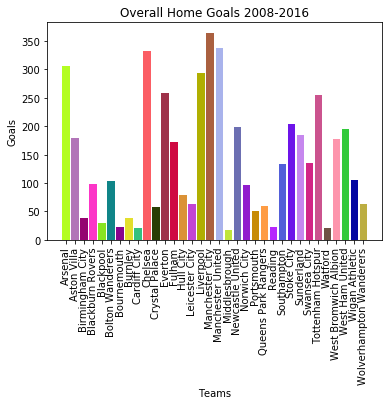

In [19]:
#visualize the sum of home goals scored by a team
from random import randint
colors = []
for i in range(35):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

import numpy as np
locations = np.arange(1,35)
heights = goals_home_overall['home_team_goal']
labels = goals_home_overall['home_team']
plt.bar(locations,heights,color=colors,tick_label=labels)
plt.title('Overall Home Goals 2008-2016')
plt.xticks(np.arange(1,35), goals_home_overall['home_team'], rotation = 90)
plt.xlabel('Teams')
plt.ylabel('Goals');

### How have different teams scored overall on away grounds?

#### In the code block below we extract and view a table with overall away goals scored by different teams to better understand their goal scoring capabilities on away grounds.

In [20]:
#view the overall number of away goals scored by a team 
goals_away_overall = df.groupby('away_team', as_index=False).sum()
goals_away_overall.drop(['stage','home_team_goal'],inplace=True, axis=1)
goals_away_overall.sort_values(by = 'away_team_goal', ascending=False)

,away_team,away_team_goal
0,Arsenal,267
9,Chelsea,250
17,Manchester United,244
16,Manchester City,241
15,Liverpool,237
28,Tottenham Hotspur,226
11,Everton,181
1,Aston Villa,156
26,Sunderland,149
31,West Ham United,131


#### In the code block below we simply display some stats about overall away goals scored.

In [21]:
#display descrpitive statistics of overall away goals 
goals_away_overall.describe()

,away_team_goal
count,34.000000
mean,103.676471
std,79.174039
min,11.000000
25%,40.500000
50%,79.500000
75%,144.500000
max,267.000000


#### In the code block below we visualize the result of our findings.

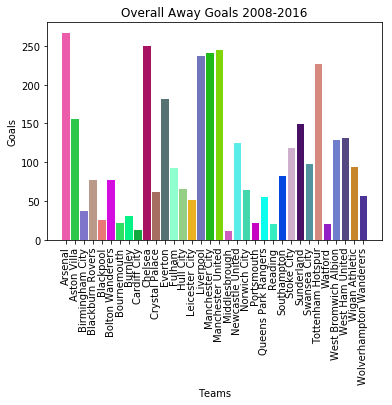

In [22]:
#visualize the sum of away goals scored by a team
from random import randint
colors = []
for i in range(35):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

import numpy as np
locations = np.arange(1,35)
heights = goals_away_overall['away_team_goal']
labels = goals_away_overall['away_team']
plt.bar(locations,heights,color=colors,tick_label=labels)
plt.title('Overall Away Goals 2008-2016')
plt.xticks(np.arange(1,35), goals_away_overall['away_team'], rotation = 90)
plt.xlabel('Teams')
plt.ylabel('Goals');

### What is the win, lose and draw percentages for a team on the home ground?

#### In the code block below we create a function to record match results with respect to the home team.

In [23]:
# Define a function for match results for the home team then print a few lines
def home_win(df):
    if df['home_team_goal'] > df['away_team_goal']:
        return 'win'
    elif df['home_team_goal'] < df['away_team_goal']:
        return 'lose'
    else:
        return 'draw'
    

df['home_result'] = df.apply(home_win, axis=1)
df.head()

,season,stage,date,home_team_goal,away_team_goal,home_team,away_team,home_result
0,2008/2009,1,2008-08-17 00:00:00,1,1,Manchester United,Newcastle United,draw
133,2008/2009,1,2008-08-16 00:00:00,1,0,Arsenal,West Bromwich Albion,win
266,2008/2009,1,2008-08-16 00:00:00,0,1,Sunderland,Liverpool,lose
418,2008/2009,1,2008-08-16 00:00:00,2,1,West Ham United,Wigan Athletic,win
513,2008/2009,1,2008-08-17 00:00:00,4,2,Aston Villa,Manchester City,win


#### In the code block below we display a count of total number of wins, losses and draws to calculate the percentages of these results.

In [24]:
#display the total count of different match results
a = df.groupby(['home_result'])['home_team'].count()
a

home_result
draw     783
lose     867
win     1390
Name: home_team, dtype: int64

#### In the code block below we visualize the result of our findings.

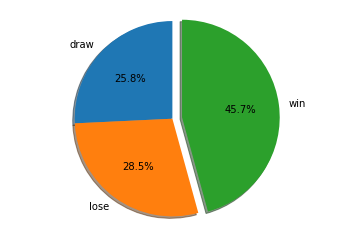

In [25]:
#visualize the win, lose and draw percentages for a team on their home ground
labels = 'draw', 'lose' , 'win'
sizes = [783, 867, 1390]
explode = (0.0, 0.0, 0.1)
fig1,ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True,startangle=90)
ax1.axis('equal')
plt.show()

### What is the trend of total number of goals scored per season?

#### In the code block below we extract a table with total number of home and away goals per season to get an insight of how teams compare on both type of grounds over the course of a complete season. 

In [26]:
# view the total goals scored in a season for all available seasons
goals_per_season = df.groupby('season',as_index=False)['home_team_goal','away_team_goal'].sum()
goals_per_season

,season,home_team_goal,away_team_goal
0,2008/2009,532,410
1,2009/2010,645,408
2,2010/2011,617,446
3,2011/2012,604,462
4,2012/2013,592,471
5,2013/2014,598,454
6,2014/2015,560,415
7,2015/2016,567,459


#### In the code block below we visualize the result of our findings.

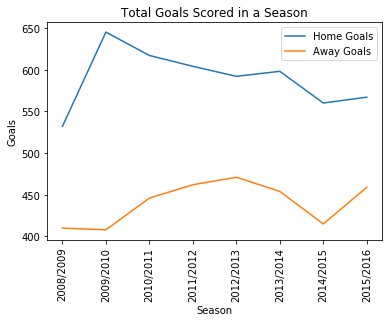

In [27]:
#visualize the result
x = goals_per_season['season']
y1 = goals_per_season['home_team_goal']
plt.plot(x, y1, label='Home Goals')
y2= goals_per_season['away_team_goal']
plt.plot(x, y2, label='Away Goals')
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Goals')
plt.title('Total Goals Scored in a Season')
plt.legend()
plt.show()

<a id='conclusions'></a>
## Conclusions:

1. Comparing the results of goal distributions across all seasons it can be concluded that teams score a higher number of goals on their home grounds than on away grounds.
2. The top 6 teams Arsenal, Chelsea, Manchester City, Manchester United, Liverpool and Tottenham Hotspurs dominate the table in terms of both home goals and away goals scored.
3. Match result trends for a team on their home ground show a 45.7% chance of a win, 28.5% chance of a loss and 25.8% chance of a draw.
4. The trend of total number of goals scored in a season clearly shows that there is a huge difference between goals scored on home ground and goals scored on the away ground, implying that visiting teams have often found it harder to score more goals. In numbers, the maximum number of home goals scored in a calender year were 617 goals in the 2010/2011 season while the highest number of away goals scored were 417 goals in the 2012/2013 season. Overall the away goal score trend is only starting to catch up to home goal score towards the end of the timeline.

<a id='limitations'></a>
## Limitations:

Though the dataset was quite vast and had many other parameters, there were following limitations:

1. The dataset only has data till the year 2016 hence it is not up to date therefore more recent trends cannot yet be analyzed.
2. A really major tournament was missing from the dataset, in which all of Europe's topmost teams play were it would have given us better insight about major teams not just from the EPL but other leagues as well.
3. The absence of a points table leaves us less equipped to compare team performances.

In [30]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0